In [1]:
from brian2 import*
%matplotlib inline
runtime = 30*ms

In [ ]:
#run this only if previous cell gives an error else skip
clear_cache('cython')

In [2]:
import numpy as np
with open('test.txt', "r") as file:
    # Read each line
    arrays_list = []
    for line in file:
        # Split the line by comma and convert to float
        numbers = [float(num) for num in line.strip().split(",")]

        # Convert the first 64 numbers into a NumPy array
        array_64 = np.array(numbers[:64])

        # Append the array to the list
        arrays_list.append(array_64)

# Convert the list of arrays into a 2D NumPy array
arrays_2d = np.array(arrays_list)
for i in range(len(arrays_2d)):
    for j in range(64):
        if(arrays_2d[i][j]<7):
            arrays_2d[i][j]= 0.01
        else:
            arrays_2d[i][j]=0.1

In [3]:

import numpy as np
import pandas as pd
k = 100
wts = []
df = pd.read_csv('weights.csv', header=None)
wts = df.values
bis = []
df2 = pd.read_csv('bias.csv', header=None)
bis = df2.values
bis = (np.array(bis))
wts = np.concatenate((wts, bis), axis=1)

wts=wts.T
#upload weights in SNN
wts_snn =[]
for i in range(0,65):
        for j in range(0,10):
            wts_snn.append((wts[i][j])/k)

wt_inp = wts_snn[:640]
wt_ext = wts_snn[640:]


In [4]:

result = []
for i in range(len(arrays_2d)):  
    start_scope()
    eqs = '''
    dv/dt = (inp-v)/tau : 1
    inp : 1
    tau : second
    '''
    #define input and output neuron groups
    I = NeuronGroup(64, eqs, threshold='v>0.008', reset='v = 0', method='exact')
    I_ext = NeuronGroup(1, eqs, threshold='v>0.008', reset='v = 0', method='exact')
    O = NeuronGroup(10, eqs, threshold='v>0.008', reset='v = 0', method='exact')
    O0 = O[0]
    O1 = O[1]
    O2 = O[2]
    O3 = O[3]
    O4 = O[4]
    O5 = O[5]
    O6 = O[6]
    O7 = O[7]
    O8 = O[8]
    O9 = O[9]

    I.tau = 6*ms
    O.tau = 6*ms
    O.inp = [0,0,0,0,0,0,0,0,0,0]
    I_ext.inp = 0.1
    I_ext.tau = 6*ms
    #define synapses
    S = Synapses(I, O, 'wt:1', on_pre='v_post += wt')
    S.connect()
    S.wt = wt_inp

    S_ext = Synapses(I_ext, O, 'wtx:1', 
                     on_pre='''v_post += wtx
                                wtx = 0''')
    S_ext.connect()
    S_ext.wtx = wt_ext
    #give input to the neurons from test cases
    I.inp = arrays_2d[i]
    
    #monitor the membrane potential and spiking behaviour of output neurons
    M_in = StateMonitor(I, 'v', record=True)
    M_out = StateMonitor(O, 'v', record=True)
    SpkO0 = SpikeMonitor(O[0])
    SpkO1= SpikeMonitor(O[1])
    SpkO2= SpikeMonitor(O[2])
    SpkO3= SpikeMonitor(O[3])
    SpkO4= SpikeMonitor(O[4])
    SpkO5= SpikeMonitor(O[5])
    SpkO6= SpikeMonitor(O[6])
    SpkO7= SpikeMonitor(O[7])
    SpkO8= SpikeMonitor(O[8])
    SpkO9= SpikeMonitor(O[9])
  
    run(runtime)

    #Monitor spinking time of each output neuron to find the one which spikes first
    spk =[]
    spk.append(min(SpkO0.t[:], default = runtime))
    spk.append(min(SpkO1.t[:], default = runtime))
    spk.append(min(SpkO2.t[:], default = runtime))
    spk.append(min(SpkO3.t[:], default = runtime))
    spk.append(min(SpkO4.t[:], default = runtime))
    spk.append(min(SpkO5.t[:], default = runtime))
    spk.append(min(SpkO6.t[:], default = runtime)) 
    spk.append(min(SpkO7.t[:], default = runtime))   
    spk.append(min(SpkO8.t[:], default = runtime))
    spk.append(min(SpkO9.t[:], default = runtime))
    min_time = min(spk)
    #append the output predicted by SNN in the result array
    result.append(spk.index(min_time))


In [5]:
print("Predicted by SNN:",result)
#read try.txt to print actual digits given as input for comparison with SNN's result
with open('test.txt', "r") as file:
    # Actual digit
    actual = []
    for line in file:
        # Split the line by comma and convert to float
        numb = [int(num) for num in line.strip().split(",")]
        # Convert the first 64 numbers into a NumPy array
        actual.append(numb[64])
print("   Actual digit :",actual)

Predicted by SNN: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 7, 7, 7, 7, 1, 7, 7, 7, 8, 7, 5, 7, 1, 4, 7, 3, 7, 7, 9, 7]
   Actual digit : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


In [6]:
count=0
#calcualting accuracy
for i in range(len(result)):
    if(result[i]==actual[i]):
        count = count+1
print("accuracy = ", ((count*100)/len(result)))


accuracy =  87.5


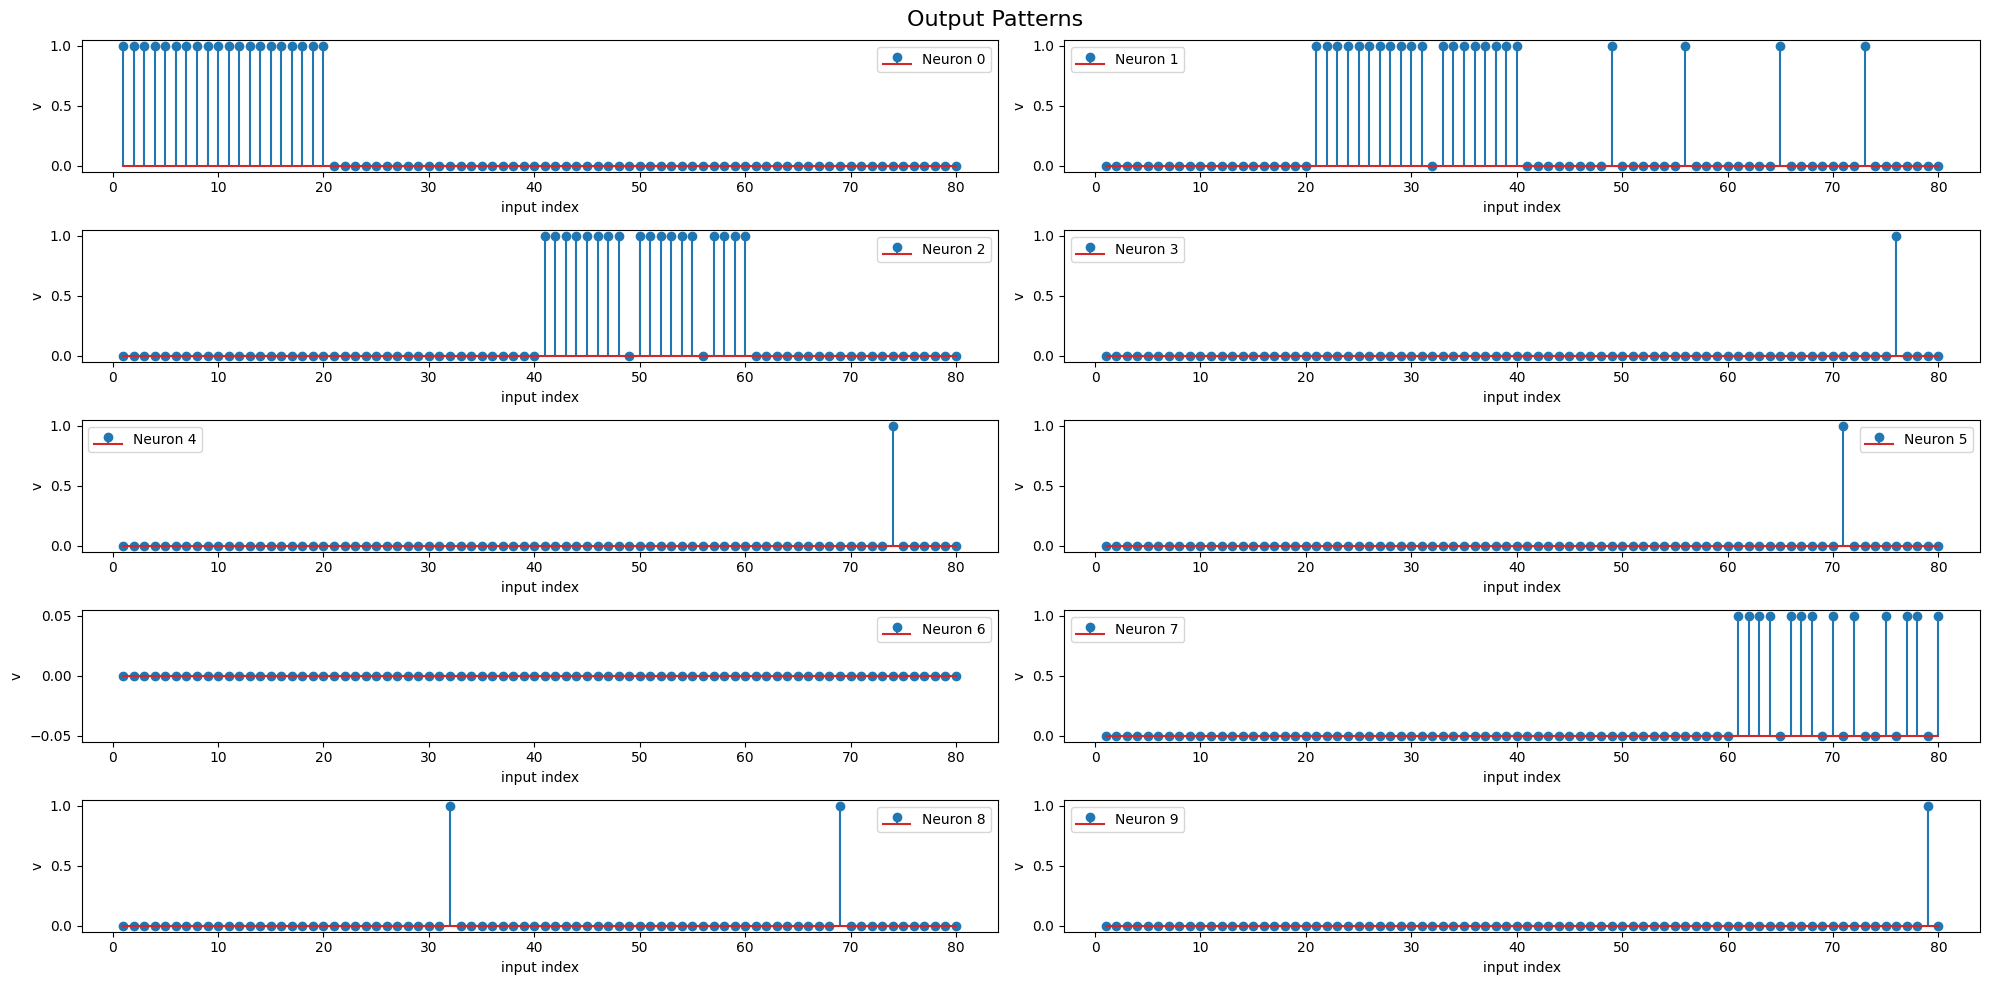

In [7]:
#plot the results
%matplotlib inline
out_spk =np.zeros((10,len(result)))
for i in range(len(result)):
    out_spk[result[i]][i] = 1
input_index = np.arange(1,(len(result)+1))

fig1, axs = plt.subplots(5, 2, figsize=(20, 10))

# Plot neuron 0
axs[0, 0].stem(input_index, out_spk[0], label='Neuron 0')
axs[0, 0].set_xlabel('input index')
axs[0, 0].set_ylabel('v')
axs[0, 0].legend()

# Plot neuron 1
axs[0, 1].stem(input_index, out_spk[1], label='Neuron 1')
axs[0, 1].set_xlabel('input index')
axs[0, 1].set_ylabel('v')
axs[0, 1].legend()

# Plot neuron 2
axs[1, 0].stem(input_index, out_spk[2], label='Neuron 2')
axs[1, 0].set_xlabel('input index')
axs[1, 0].set_ylabel('v')
axs[1, 0].legend()

# Plot neuron 3
axs[1, 1].stem(input_index, out_spk[3], label='Neuron 3')
axs[1, 1].set_xlabel('input index')
axs[1, 1].set_ylabel('v')
axs[1, 1].legend()

# Plot neuron 4
axs[2, 0].stem(input_index, out_spk[4], label='Neuron 4')
axs[2, 0].set_xlabel('input index')
axs[2, 0].set_ylabel('v')
axs[2, 0].legend()

# Plot neuron 5
axs[2, 1].stem(input_index, out_spk[5], label='Neuron 5')
axs[2, 1].set_xlabel('input index')
axs[2, 1].set_ylabel('v')
axs[2, 1].legend()

# Plot neuron 6
axs[3, 0].stem(input_index, out_spk[6], label='Neuron 6')
axs[3, 0].set_xlabel('input index')
axs[3, 0].set_ylabel('v')
axs[3, 0].legend()

# Plot neuron 7
axs[3, 1].stem(input_index, out_spk[7], label='Neuron 7')
axs[3, 1].set_xlabel('input index')
axs[3, 1].set_ylabel('v')
axs[3, 1].legend()

# Plot neuron 8
axs[4, 0].stem(input_index, out_spk[8], label='Neuron 8')
axs[4, 0].set_xlabel('input index')
axs[4, 0].set_ylabel('v')
axs[4, 0].legend()

# Plot neuron 9
axs[4, 1].stem(input_index, out_spk[9], label='Neuron 9')
axs[4, 1].set_xlabel('input index')
axs[4, 1].set_ylabel('v')
axs[4, 1].legend()

fig1.suptitle('Output Patterns', fontsize=16)
# Tighten the layout
plt.tight_layout()

# Display the plot
plt.show()


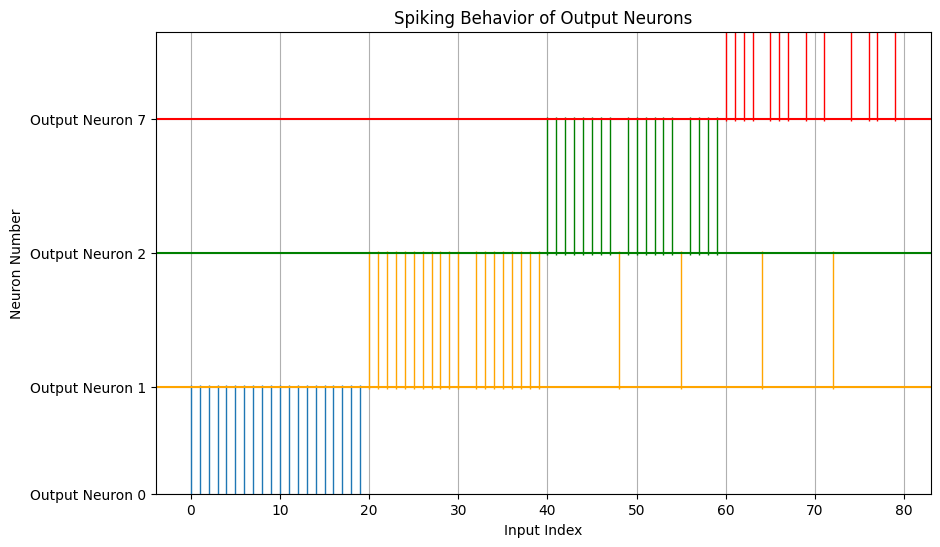

In [8]:
import matplotlib.pyplot as plt
import numpy as np
line_length =100
# Generate sample spike data for 4 neurons
num_samples = 1000
neuron1_spikes = out_spk[0]
neuron2_spikes = out_spk[1]
neuron3_spikes = out_spk[2]
neuron4_spikes = out_spk[7]

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot spikes for each neuron
plt.plot(np.where(neuron1_spikes == 1)[0], np.ones_like(np.where(neuron1_spikes == 1)[0]), '|', markersize=line_length, label='Neuron 1')
plt.plot(np.where(neuron2_spikes == 1)[0], 2 * np.ones_like(np.where(neuron2_spikes == 1)[0]), '|', markersize=line_length, color='orange',label='Neuron 2')
plt.plot(np.where(neuron3_spikes == 1)[0], 3 * np.ones_like(np.where(neuron3_spikes == 1)[0]), '|', markersize=line_length,color='green', label='Neuron 3')
plt.plot(np.where(neuron4_spikes == 1)[0], 4 * np.ones_like(np.where(neuron4_spikes == 1)[0]), '|', markersize=line_length,color='red', label='Neuron 4')
plt.axhline(y=1.5, color='orange', linestyle='-', label='y=1.5')
plt.axhline(y=2.5, color='green', linestyle='-', label='y=2.5')
plt.axhline(y=3.5, color='red', linestyle='-', label='y=3.5')
# Add labels and title
plt.xlabel('Input Index')
plt.ylabel('Neuron Number')
plt.title('Spiking Behavior of Output Neurons')
plt.yticks([0.7, 1.5, 2.5, 3.5], ['Output Neuron 0', 'Output Neuron 1', 'Output Neuron 2', 'Output Neuron 7'])
#plt.legend()

# Show the plot
plt.grid(True)
plt.show()


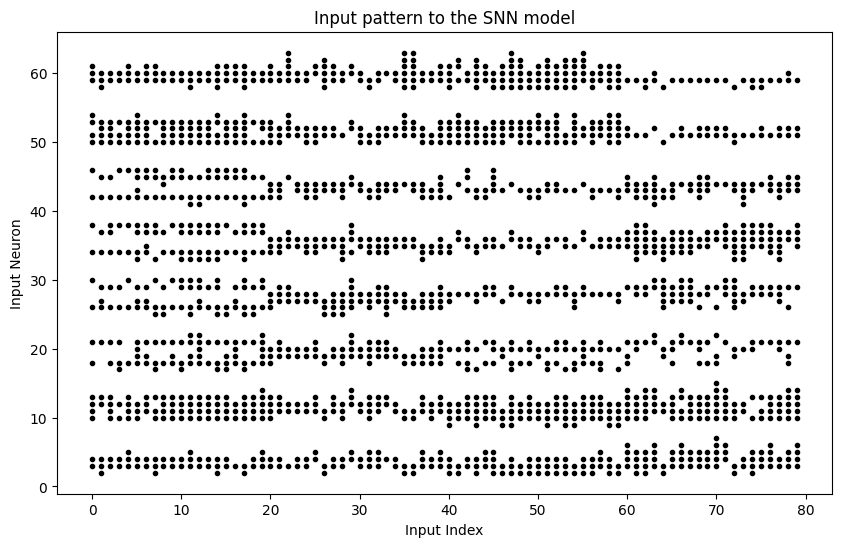

In [46]:
array_res = []
for i in range(len(arrays_2d)):
    a = []
    for j in range(64):
        if(arrays_2d[i][j] == 0.1):
            a.append(j)
    array_res.append(a)


import matplotlib.pyplot as plt
import numpy as np

# Plotting the raster plot
plt.figure(figsize=(10, 6))
for i, sublist in enumerate(array_res):
    plt.plot([i] * len(sublist), sublist, marker='o',  markersize=3, linestyle='None', color='black')  # Plot each sublist's values
plt.xlabel('Input Index')
plt.ylabel('Input Neuron')
plt.title('Input pattern to the SNN model')
plt.show()